# Project 4: Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [115]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Camera Calibration
Calibrates camera using chessboard image files in camera_cal folder

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function. Which return the calibration parameters(`mtx` and `dist`) we need for `cv2.undistort()` function.

In [116]:
# prepare object points, like
objp = np.zeros((6 * 9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Get the image size of calibration images
img = cv2.imread("camera_cal/calibration1.jpg")
img_size = (img.shape[1], img.shape[0])

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# Get camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)



### 1.1 Example of a distortion corrected calibration image
This is an example of undistortion with the calibration parameters we get in last step.

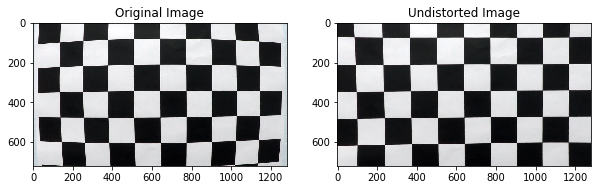

In [117]:
img = cv2.imread("camera_cal/calibration1.jpg")
img_undistort = cv2.undistort(img, mtx, dist, None, mtx)

# Plot the original image and undistorted image
plt.figure(figsize=(10,4));
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img);

plt.subplot(1,2,2)
plt.title('Undistorted Image')
plt.imshow(img_undistort);

## 2. Pipeline (single images)

### 2.1 Image undistortion
First, I apply `cv2.undistort()` function with calibration parameters `mtx` and `dist` on our input image.

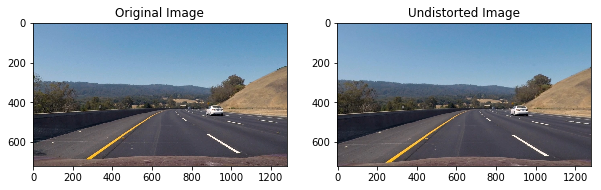

In [46]:
img = cv2.imread("test_images/test3.jpg")
img_size = (img.shape[1], img.shape[0])

img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_undistort = cv2.undistort(img_RGB, mtx, dist, None, mtx)

# Plot the original image and undistorted image
plt.figure(figsize=(10,4));
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img_RGB);

plt.subplot(1,2,2)
plt.title('Undistorted Image')
plt.imshow(img_undistort);

### 2.2 Image Thresholding
I used a combination of color and gradient thresholds to generate a binary image.  
Here's an example of my output for this step.

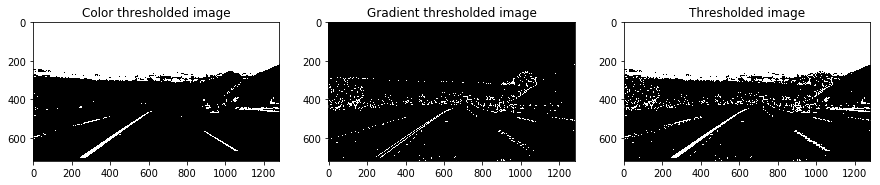

In [96]:
# convert image from RGB to HLS and gray for thresholding
img_HLS = cv2.cvtColor(img_undistort, cv2.COLOR_RGB2HLS)
img_gray = cv2.cvtColor(img_undistort, cv2.COLOR_RGB2GRAY)

# Color thresholding
color_min = 90
color_max = 255
color_bin = np.zeros_like(img_HLS[:,:,2])
color_bin[(img_HLS[:,:,2] >= color_min) & (img_HLS[:,:,2] <= color_max)] = 1

# Gradient thresholding (apply absolute sobel operator on x direction)
grad_min = 20
grad_max = 100
abs_sobel = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 1, 0))
scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
sobel_bin = np.zeros_like(scaled_sobel)
sobel_bin[(scaled_sobel >= grad_min) & (scaled_sobel <= grad_max)] = 1

# Combine two binary images
comb_bin = np.zeros_like(sobel_bin)
comb_bin[(color_bin == 1) | (sobel_bin == 1)] = 1

# Plot the thresholded images
plt.figure(figsize=(15,4));
plt.subplot(1,3,1)
plt.title('Color thresholded image')
plt.imshow(color_bin,cmap ='gray');

plt.subplot(1,3,2)
plt.title('Gradient thresholded image')
plt.imshow(sobel_bin,cmap ='gray');

plt.subplot(1,3,3)
plt.title('Thresholded image')
plt.imshow(comb_bin,cmap ='gray');

### 2.3 Perspective transform
The next code cell takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```
src = np.float32(
    [[595, 450], 
     [203, 720], 
     [1127, 720], 
     [685, 450]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 595, 450      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 685, 450      | 960, 0        |

I verified that my perspective transform was working as expected by plotting the original straight line image and wraped image as below. The wraped image shows two straight line in birdeye view.

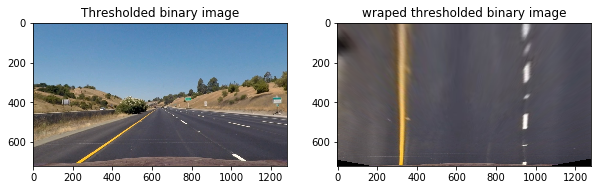

In [48]:
# Take the straight line image to find the perspective transform parameters
test = cv2.imread("test_images/straight_lines1.jpg")
test_RGB = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test_undistort = cv2.undistort(test_RGB, mtx, dist, None, mtx)


# Define the src and dst points
src = np.float32(
    [[595, 450], 
     [203, 720], 
     [1127, 720], 
     [685, 450]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

# Get perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Apply the perspective transform on image to check if the transformation are right
warped_test = cv2.warpPerspective(test_undistort, M, img_size, flags=cv2.INTER_LINEAR)

# Plot the original and wraped images
plt.figure(figsize=(10,4));
plt.subplot(1,2,1)
plt.title('Thresholded binary image')
plt.imshow(test_undistort);

plt.subplot(1,2,2)
plt.title('wraped thresholded binary image')
plt.imshow(warped_test);

Then I apply this perspective transform matrix `M` on my combined binary image, the result shows as below.

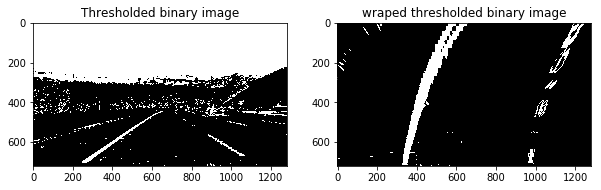

In [98]:
# Apply the perspective transform on thresholded binary image
warped_bin = cv2.warpPerspective(comb_bin, M, img_size, flags=cv2.INTER_LINEAR)

# Plot the original and wraped binary images
plt.figure(figsize=(10,4));
plt.subplot(1,2,1)
plt.title('Thresholded binary image')
plt.imshow(comb_bin,cmap ='gray');

plt.subplot(1,2,2)
plt.title('wraped thresholded binary image')
plt.imshow(warped_bin,cmap ='gray');

### 2.4 Lane-line identification and polynomial fitting

Then I did some other stuff and fit my lane lines with a 2nd order polynomial.
The result with selected line segments in diffrent color and fitted 2nd order polynomial is shown as below.

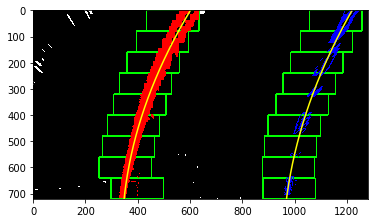

In [99]:
# Take a histogram of the bottom half of the image
histogram = np.sum(warped_bin[warped_bin.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped_bin, warped_bin, warped_bin))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped_bin.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_bin.shape[0] - (window+1)*window_height
    win_y_high = warped_bin.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_bin.shape[0]-1, warped_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img);
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280);
plt.ylim(720, 0);

### 2.5 Calculate radius of curvature of the lane and the position of the vehicle
This code cell shows how I calculate the radius of curvature of the lane and the position of the vehicle with respect to the center of the lane.

In [111]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Use the bottom y for radius calculation
y_eval = np.max(ploty) * ym_per_pix
left_curverad_cr = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad_cr = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
curverad_cr = (left_curverad_cr+right_curverad_cr)/2
offset = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
print('Radius of curvature of the lane is',curverad_cr,'meter')
print('Vehicle is',offset,'meter right of center of the lane')

Radius of curvature of the lane is 510.715491401 meter
Vehicle is 0.0979216000903 meter right of center of the lane


### 2.6 Final result (single image)
In this code cell, I use the perspective transform parameters `Minv` to transform the fitted lane lines back to camera image, and plot the lane and radius/offset on our original image.

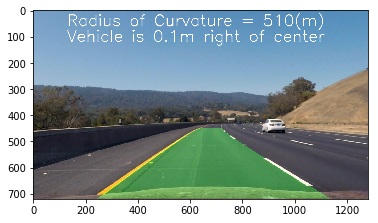

In [114]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_bin).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 

# Combine the result with the original image
result = cv2.addWeighted(img_undistort, 1, newwarp, 0.3, 0)

# Write curvature and offset info on image
Text1 = "Radius of Curvature = " + str(int(curverad_cr)) + "(m)"
if offset >= 0:
    Text2 = "Vehicle is " + str(round(offset,2)) + "m right of center"
else:
    Text2 = "Vehicle is " + str(round(-offset,2)) + "m left of center"
fontScale=2
thickness=2    
fontFace = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result, Text1, (130,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
cv2.putText(result, Text2, (130,120), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
        
plt.imshow(result);

## 3. Pipeline (video)
### 3.0 Function definition of pipeline for video processing

In [47]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
def param_init():
    # Get undistortion parameters
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob('camera_cal/*.jpg')
    # Get the image size of calibration images
    img = cv2.imread("camera_cal/calibration1.jpg")
    img_size = (img.shape[1], img.shape[0])

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    # Get perspective transform matrix
    src = np.float32(
        [[595, 450], 
         [203, 720], 
         [1127, 720], 
         [685, 450]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return mtx,dist,M,Minv,img_size

In [49]:
def process_threshold(img):
    # convert image from RGB to HLS and gray for thresholding
    img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Color thresholding
    color_min = 90
    color_max = 255
    color_bin = np.zeros_like(img_HLS[:,:,2])
    color_bin[(img_HLS[:,:,2] >= color_min) & (img_HLS[:,:,2] <= color_max)] = 1

    # Gradient thresholding (apply absolute sobel operator on x direction)
    grad_min = 20
    grad_max = 100
    abs_sobel = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 1, 0))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_bin = np.zeros_like(scaled_sobel)
    sobel_bin[(scaled_sobel >= grad_min) & (scaled_sobel <= grad_max)] = 1

    # Combine two binary images
    comb_bin = np.zeros_like(sobel_bin)
    comb_bin[(color_bin == 1) | (sobel_bin == 1)] = 1
    
    return comb_bin

In [50]:
def sanity_check(left_fit,right_fit):
    # check if slopes of left and right lanes are similar
    slope_l_1 = 2*left_fit[0]*720+left_fit[1]
    slope_r_1 = 2*right_fit[0]*720+right_fit[1]
    slope_diff_1 =  np.abs(slope_l_1-slope_r_1)
    slope_l_2 = 2*left_fit[0]*460+left_fit[1]
    slope_r_2 = 2*right_fit[0]*460+right_fit[1]
    slope_diff_2 =  np.abs(slope_l_2-slope_r_2)
    
    if slope_diff_1 < 0.5 and slope_diff_2 < 0.5:
        status = True
    else:
        status = False
        
    return(status)

In [52]:
def lane_finding(img_bin):
    global last_left_fit
    global last_right_fit
    global last_curverad
    global last_offset
    
    histogram = np.sum(img_bin[img_bin.shape[0]/2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(img_bin.shape[0]/nwindows)
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = img_bin.shape[0] - (window+1)*window_height
        win_y_high = img_bin.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each (in pixel)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Fit a second order polynomial to each (in meter)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # radius and offset calculation
    y_eval = img_bin.shape[0] * ym_per_pix
    left_curverad_cr = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_cr = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curverad = (left_curverad_cr+right_curverad_cr)/2
    offset = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    if sanity_check(left_fit,right_fit) == False and last_left_fit != None:
        left_fit = last_left_fit
        right_fit = last_right_fit
        curverad = last_curverad
        last_offset = last_offset
    last_left_fit = left_fit
    last_right_fit = right_fit
    last_curverad = curverad
    last_offset = offset
    
    return left_fit,right_fit,curverad,offset

In [53]:
def draw_lines(img_original,Minv,curverad,offset,img_size,left_fit,right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_original[:,:,1]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Generate x and y values for plotting
    ploty = np.linspace(0, warp_zero.shape[0]-1, warp_zero.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_original, 1, newwarp, 0.3, 0)
    # Write curvature and offset info on image
    Text1 = "Radius of Curvature = " + str(int(curverad)) + "(m)"
    if offset >= 0:
        Text2 = "Vehicle is " + str(round(offset,2)) + "m right of center"
    else:
        Text2 = "Vehicle is " + str(round(-offset,2)) + "m left of center"
    fontScale=2
    thickness=2    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, Text1, (130,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(result, Text2, (130,120), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    
    return result

In [54]:
def process_img(img):
    # Undistortion
    img_undistort = cv2.undistort(img, mtx, dist, None, mtx)
    # Threshold
    img_bin = process_threshold(img_undistort)
    # Perspective Transform
    img_bin_warped = cv2.warpPerspective(img_bin, M, img_size, flags=cv2.INTER_LINEAR)
    # Lane finding
    left_fit,right_fit,curverad,offset = lane_finding(img_bin_warped)
    # Draw lines
    img_result = draw_lines(img_undistort,Minv,curverad,offset,img_size,left_fit,right_fit)
    
    return img_result

### 3.1 Test on single image

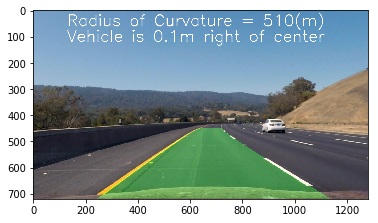

In [55]:
# Load image
img = cv2.imread("test_images/test3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Init calibration and perspective transform parameters
mtx,dist,M,Minv,img_size = param_init()
# Process image
out_img = process_img(img)
# Plot output image
plt.imshow(out_img);

### 3.2 Pipeline on video

In [56]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

# Init calibration and perspective transform parameters
mtx,dist,M,Minv,img_size = param_init()
# Video processing
output = 'final_video.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(process_img)
video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video final_video.mp4
[MoviePy] Writing video final_video.mp4



100%|█████████▉| 1260/1261 [02:35<00:00,  7.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_video.mp4 



## 4. Discussion

This is a nice pratice to combine all the stuffs we learn in the computer vision lessons together.

First of all is the camera calibration, using the chessboard to get the camera calibration info and applying this parameters on further image processing and video processing.

Then the thresholding by color and gradient gives us a great hints about where are possible lane segements. For the purpose of the project, I only apply the color threshold on S channel and sobel gradient threshold and combine both thresholded binary images. But for more precise work, we could also take other threshold methods into account. For example the color threshold of white and yellow.

After we get the binary image in camera plane, we need to transform it back to real world coordinate. So I use the straight lane line image to find the perspective transform matrix. Once the matrix is found, we can use this matrix for all images captured by this camera.

Applying the perspective transform on the thresholded binary image, we can get a wraped binary image. And then histogram and sliding window methods are employed to find the left and right lane line. Afterwards, I use `np.polyfit` function to fit the line samples to 2nd order polynomial.

After this line fitting process, I add the sanity check function after the first submission, to compare the left and right lanes slope, if this line fitting result is not reasonable, I will just keep the result from last frame. This process is pretty important for the pipeline on video, because some road might be repainted and covered by the shadow, after implementing this check, the lane extraction is more robust than before.

Finally I use the the inversed perspective transform matrix `Minv` to plot the fitted lane lines back to original inout image.